# Using beamforming to localize oscillatory power modulations

The aim of this section is to localise modulations in oscillatory power using the Dynamical Imaging of Coherent Sources (DICS) method [1]. DICS is a beamforming technique based on spatial filtering in the frequency domain. For each grid point within the brain, a spatial filter is computed using the forward model in conjunction with the cross-spectral density (CSD) matrix. Spectral estimates are obtained via a multitaper approach. This method enables the estimation of power modulations at each grid point, which are subsequently mapped onto the individual structural MRIs. 


## Preparation

Import the relevant Python modules:

In [1]:
import os
import os.path as op
import numpy as np

import mne
from mne_bids import BIDSPath
from mne.cov import compute_covariance
from mne.beamformer import make_dics, apply_dics_csd
from mne.time_frequency import csd_multitaper

## File overview

The chapter relies on the input files (embedded in the BIDS structure):

    <BIDS_ROOT>/derivatives/Analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_epo.fif

    <BIDS_ROOT>/derivatives/Analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_src.fif
    <BIDS_ROOT>/derivatives/FreeSurfer
    <BIDS_ROOT>/derivatives/Analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_fwd.fif

Set the paths and name for the data. Note that these will depend on your local setup.


## Defining files names and paths



In [2]:
subject = '01'
session = '01'
task = 'SpAtt'  # name of the task
run = '01'  
meg_suffix = 'meg'
epo_suffix = 'epo'
mri_suffix = 'T1w'
bem_suffix = 'bem-sol'
src_suffix = 'src'
fwd_suffix = 'fwd'

#data_path='C:/Users/rakshita/Documents/Cerca_raw_files'
data_path = '/Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif'


bids_root = op.join(data_path, "Cerca_Spatt_BIDS")
deriv_root = op.join(bids_root, "derivatives/analysis")

bids_path = BIDSPath(subject=subject, session=session,
            task=task, run=run, suffix=epo_suffix, datatype='meg',
            root=deriv_root, extension='.fif', check=False)


fwd_fname = bids_path.basename.replace(epo_suffix, fwd_suffix)
fwd_file = op.join(bids_path.directory, fwd_fname)
src_file = fwd_file.replace(fwd_suffix, src_suffix)
bem_file = fwd_file.replace(fwd_suffix, bem_suffix)


fs_subject = 'T1s'
fs_root = op.join(bids_root, 'derivatives', 'FreeSurfer')


## The forward model

In this example we will use the forward model calculated in the previous section. The forward model is constructed for the OPM sensors with respect to the volumetric forward solution (not the brain surface solution). Note that will make use of the sensors information from all three axes. 


In [3]:
fwd = mne.read_forward_solution(fwd_file)

Reading forward solution from /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_fwd.fif...
    Reading a source space...
    [done]
    1 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (12983 sources, 192 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame



## Reading the trials

Now read the trials (epochs) for all trial types:


In [4]:
epochs = mne.read_epochs(bids_path.fpath, proj = False)

Reading /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_epo.fif ...
    Read a total of 8 projection items:
        HFC: l=1 m=-1 (1 x 180) active
        HFC: l=1 m=0 (1 x 180) active
        HFC: l=1 m=1 (1 x 180) active
        HFC: l=2 m=-2 (1 x 180) active
        HFC: l=2 m=-1 (1 x 180) active
        HFC: l=2 m=0 (1 x 180) active
        HFC: l=2 m=1 (1 x 180) active
        HFC: l=2 m=2 (1 x 180) active
    Found the data of interest:
        t =    -749.33 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
219 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 8)


Will will subsequently focus on activity in the Z-axis sensors:

In [5]:
OPMZ = [item for item in epochs.info['ch_names'] if item.endswith("Z") and not item.startswith("BNC")]
epochs = epochs.copy().pick(OPMZ)

As a subselection of sensors were done, the projection must be re-normalized:

In [6]:
epochs.info.normalize_proj()


## Source modeling of modulations of alpha band activity
### Calculating the cross-spectral density matrices for the alpha band

The spatial filters in the DICS beamforming approach are calculated using the forward model and the cross-spectral density (CSD) matrices. We here focus on the -0.7 to -0.2 s interval prior to the onset of the cues and the 0.1 to 0.6 s (ΔT = 0.5 s) interval after the cue onset. During the cue-target interval, the alpha band activity is suppressed (see the section Time-Frequency Representations of Power).

We start by calculating the CSDs for the 8 to 12 Hz alpha band for all conditions and the pre- and post-interval. Since we are using the multitaper approach we are defining the bandwidth to ΔF = 3 Hz. This results in one taper (as N < ΔF ΔT =  3 x 0.5  = 1.5 ).


In [7]:
print('Baseline Interval')
csd_aleft_pre   = csd_multitaper(epochs['cue_Left'],  fmin=8, fmax=12, tmin=-0.7, tmax=-0.2, bandwidth = 3, low_bias = True, verbose = False, n_jobs=-1)
csd_aright_pre  = csd_multitaper(epochs['cue_Right'], fmin=8, fmax=12, tmin=-0.7, tmax=-0.2, bandwidth = 3, low_bias = True,verbose = False, n_jobs=-1)

print('Cue Interval')
csd_aleft_cue =  csd_multitaper(epochs['cue_Left'],  fmin=8, fmax=12, tmin=0.1, tmax=0.6, bandwidth = 3,  low_bias = True, verbose = False, n_jobs=-1)
csd_aright_cue = csd_multitaper(epochs['cue_Right'], fmin=8, fmax=12, tmin=0.1, tmax=0.6, bandwidth = 3,  low_bias = True, verbose = False, n_jobs=-1)

Baseline Interval
Cue Interval


The spatial filters must be based on the covariance matrices combined ('common spatial filter'). Therefore the CSDs are averaged:

In [8]:
csd_acommon1 = csd_aleft_cue.copy()
csd_acommon1._data = (csd_aleft_cue._data + csd_aright_cue._data + 
                         csd_aleft_pre._data + csd_aright_pre._data)/4

For calculating the spatial filters we also need to derive the rank of the CSD. It will be similar to the the rank of the coveriance matrix:

In [9]:

rank = mne.compute_rank(epochs, tol=1e-5, tol_kind='relative', proj = True)
print(rank)

Computing rank from data with rank=None
    Estimated rank (mag): 52
    MAG: rank 52 computed from 60 data channels with 8 projectors
{'mag': 52}


Note that the rank is 52 eventhough there were 60 sensors. The rank deficiency is caused by the HFC and the ICA algorithms and therefore requires a regulatization before inverting in the beamforming calculation.

### Derive the spatial filters for the alpha band

Now calculate the filters using the forward model `fwd` and the combined CSD matrix `csd_common`. The filters are regularized by loading the diagonal of the covariance matrix with 5% of the sensor power. For each source, the orientation is optimized to maximize the output power. 

Since we are using OPM data, which consists only of magnetometers, the issue of scale differences between sensor types does not apply. Depth bias compensation is applied by setting `depth=0`, allowing for direct comparison across conditions or intervals. The relative comparisons mitigate depth bias. The `mean` in `csd_common.mean()` averages the CSDs over the selected frequency range.

Given that the covariance (or CSD) matrices may still be rank-deficient — though minimally in this case — MNE-Python computes a truncated pseudo-inverse using the effective rank. For the data matrix **X** with rank `k`, the truncated pseudo-inverse **X⁺** is computed via singular value decomposition as:

**X = UΣVᵀ**,  
**X⁺ = VₖΣₖ⁻¹Uₖᵀ**,

where the first `k` diagonal values of Σ and the first `k` columns of **U** and **V** are retained.

In [10]:
afilters1 = make_dics(epochs.info, fwd, csd_acommon1.mean() , noise_csd= None, 
                    reg=0.05, pick_ori='max-power', reduce_rank=True, real_filter=True, rank=rank, depth = 0)

Identifying common channels ...
Dropped the following channels:
['O8 H5 X', 'F12 D8 Y', 'T2 B2 X', 'T14 H6 Z', 'O6 H1 X', 'F1 A1 Y', 'F3 A3 Y', 'Oz G5 Y', 'P9 E3 X', 'T6 D6 Y', 'O4 H8 Y', 'O6 H1 Y', 'P3 E1 Y', 'F2 B7 X', 'T10 D5 X', 'O10 H7 X', 'O3 G6 Y', 'T3 C4 Y', 'F9 A4 X', 'F8 B1 Y', 'C7 E4 X', 'T10 D5 Y', 'T12 H2 Y', 'O3 G6 X', 'Pz F8 X', 'C5 C1 X', 'P3 E1 X', 'T4 D1 X', 'P12 F4 X', 'T7 C8 X', 'P11 E6 X', 'P2 F3 X', 'O1 E5 X', 'P11 E6 Y', 'T13 G8 Y', 'T12 H2 X', 'F6 B8 Y', 'Iz H4 X', 'T5 C5 X', 'O9 G3 Y', 'Fpz A2 Y', 'P6 F2 X', 'P5 C6 X', 'O5 G4 X', 'F3 A3 X', 'T14 H6 Y', 'P12 F4 Y', 'C3 C2 Y', 'F5 A6 X', 'P9 E3 Y', 'P6 F2 Y', 'T11 G7 Y', 'P7 E7 Y', 'F11 A8 X', 'Oz G5 X', 'C4 D7 X', 'T13 G8 X', 'C8 F7 X', 'O5 G4 Y', 'AFz B4 X', 'C1 A7 X', 'Cz E2 X', 'F8 B1 X', 'T1 C7 Y', 'F4 B6 Y', 'F6 B8 X', 'F1 A1 X', 'O2 H3 X', 'F10 B3 Y', 'P10 F5 X', 'O2 H3 Y', 'P8 F1 Y', 'T8 D2 Y', 'Iz H4 Y', 'T7 C8 Y', 'F11 A8 Y', 'P4 D3 Y', 'Pz F8 Y', 'O4 H8 X', 'P10 F5 Y', 'O8 H5 Y', 'T3 C4 X', 'T5 C5 Y', 

In [11]:
stc_aleft_cue, freqs = apply_dics_csd(csd_aleft_cue.mean(), afilters1)
stc_aright_cue, freqs = apply_dics_csd(csd_aright_cue.mean(), afilters1)

stc_aleft_pre, freqs  = apply_dics_csd(csd_aleft_pre.mean(), afilters1)
stc_aright_pre, freqs  = apply_dics_csd(csd_aright_pre.mean(), afilters1)

Computing DICS source power...
[done]
Computing DICS source power...
[done]
Computing DICS source power...
[done]
Computing DICS source power...
[done]


Calculate the relative change in power; i.e. the change in alpha power comparing the interval before and after the moving grating onset. Note that we are always comparing intervals or conditions in order to reduce the depth bias :

In [12]:
stc_arel = stc_aleft_cue.copy()
stc_arel = ((stc_aleft_cue + stc_aright_cue) - (stc_aleft_pre + stc_aright_pre)) / (stc_aleft_pre + stc_aright_pre)

Calculate the change in relative power for comparing the right versus left attention conditions during the moving gratings interval:

### Plotting the alpha band modulation

Now plot the source results:

<SourceSpaces: [<volume, shape=(31, 38, 33), n_used=12983>] head coords, subject 'T1s', ~74.5 MiB>
Showing: t = 0.000 s, (-21.3, -55.5, 11.3) mm, [11, 6, 14] vox, 16689 vertex
Using control points [0.23312766 0.25293381 0.33955248]


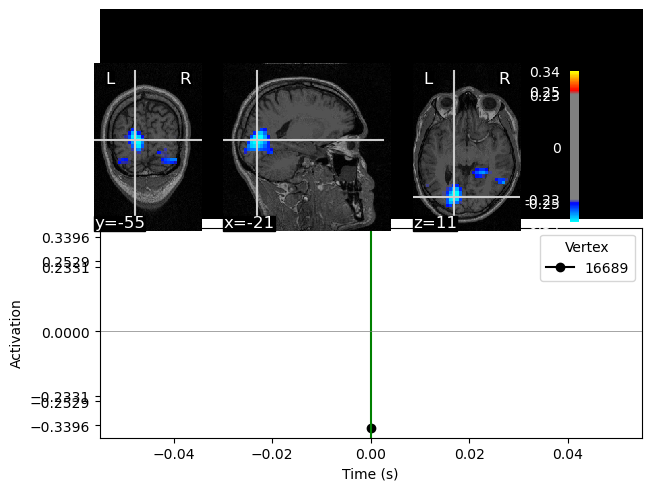

In [13]:
src = fwd['src']
print(src)

%matplotlib inline
stc_arel.plot(src=src, subject=fs_subject, subjects_dir=fs_root, mode='stat_map', verbose = True);

Note the strong alpha depression in visual areas.

### Calculating the modulation in alpha power with attention

This will be done for the modulation in the cue-targer interval for attention right minus left. The first step is to contruct a cross-spectral density matrix for the cue-target interval combined for left and right conditions:

In [14]:
csd_acommon2 = csd_aleft_cue.copy()
csd_acommon2._data = (csd_aleft_cue._data + csd_aright_cue._data)/2

subsequently the respective filter is estimated:

In [15]:
afilters2 = make_dics(epochs.info, fwd, csd_acommon2.mean() , noise_csd= None, 
                    reg=0.05, pick_ori='max-power', reduce_rank=True, real_filter=True, rank=rank, depth = 0)

Identifying common channels ...
Dropped the following channels:
['O8 H5 X', 'F12 D8 Y', 'T2 B2 X', 'T14 H6 Z', 'O6 H1 X', 'F1 A1 Y', 'F3 A3 Y', 'Oz G5 Y', 'P9 E3 X', 'T6 D6 Y', 'O4 H8 Y', 'O6 H1 Y', 'P3 E1 Y', 'F2 B7 X', 'T10 D5 X', 'O10 H7 X', 'O3 G6 Y', 'T3 C4 Y', 'F9 A4 X', 'F8 B1 Y', 'C7 E4 X', 'T10 D5 Y', 'T12 H2 Y', 'O3 G6 X', 'Pz F8 X', 'C5 C1 X', 'P3 E1 X', 'T4 D1 X', 'P12 F4 X', 'T7 C8 X', 'P11 E6 X', 'P2 F3 X', 'O1 E5 X', 'P11 E6 Y', 'T13 G8 Y', 'T12 H2 X', 'F6 B8 Y', 'Iz H4 X', 'T5 C5 X', 'O9 G3 Y', 'Fpz A2 Y', 'P6 F2 X', 'P5 C6 X', 'O5 G4 X', 'F3 A3 X', 'T14 H6 Y', 'P12 F4 Y', 'C3 C2 Y', 'F5 A6 X', 'P9 E3 Y', 'P6 F2 Y', 'T11 G7 Y', 'P7 E7 Y', 'F11 A8 X', 'Oz G5 X', 'C4 D7 X', 'T13 G8 X', 'C8 F7 X', 'O5 G4 Y', 'AFz B4 X', 'C1 A7 X', 'Cz E2 X', 'F8 B1 X', 'T1 C7 Y', 'F4 B6 Y', 'F6 B8 X', 'F1 A1 X', 'O2 H3 X', 'F10 B3 Y', 'P10 F5 X', 'O2 H3 Y', 'P8 F1 Y', 'T8 D2 Y', 'Iz H4 Y', 'T7 C8 Y', 'F11 A8 Y', 'P4 D3 Y', 'Pz F8 Y', 'O4 H8 X', 'P10 F5 Y', 'O8 H5 Y', 'T3 C4 X', 'T5 C5 Y', 

Then apply the filter for the left and right attention conditions

In [16]:
stc_aleft_cue, freqs = apply_dics_csd(csd_aleft_cue.mean(), afilters2)
stc_aright_cue, freqs = apply_dics_csd(csd_aright_cue.mean(), afilters2)

Computing DICS source power...
[done]
Computing DICS source power...
[done]


Finally calculate the relative attend left verus right contrasts:

In [18]:
stc_aRvsL = stc_aleft_cue.copy()
stc_aRvsL = (stc_aright_cue -stc_aleft_cue) / (stc_aright_cue + stc_aleft_cue)

Showing: t = 0.000 s, (48.7, -30.5, -18.7) mm, [25, 11, 8] vox, 9790 vertex
Using control points [0.11296216 0.1215339  0.16489645]


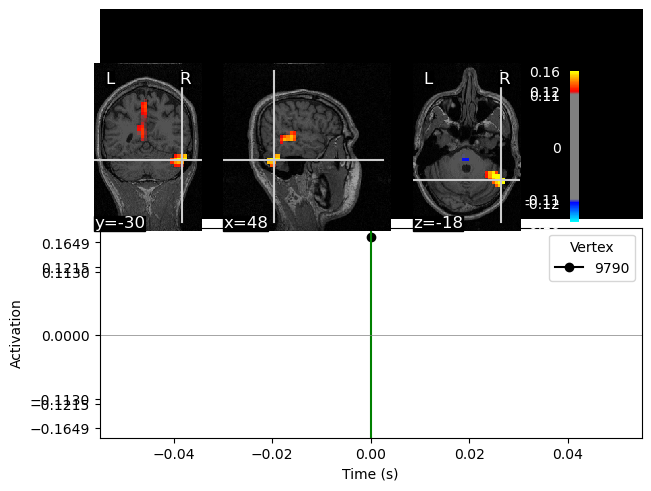

In [19]:
%matplotlib inline
stc_aRvsL.plot(src=src, subject=fs_subject, subjects_dir=fs_root);

The sources in the right posterior areas reflect the relative increase in alpha. This is due to allocation to the right hemifield resulting in a relative alpha power increase in the right hemisphere.


## Source modeling of modulations of gamma band activity

We will next localise the sources associated with the modulation in the 70 - 90 Hz gamma band. For this, we will apply the multitaper approach to ensure suffient spectral smoothing.

As a first step, calculate the CSD for the pre- and post-interval as well as all conditions. The bandwidth here is 2ΔF = 8 Hz and the time window ΔT = 0.500 s. This results in 3 tapers (as N < ΔF ΔT).


In [20]:
print('Pre')
csd_gleft_pre   = csd_multitaper(epochs['cue_Left'],  fmin=70, fmax=80, tmin=-0.7, tmax=-0.2, bandwidth = 8, adaptive=True, low_bias = True,verbose = False, n_jobs=-1)
csd_gright_pre  = csd_multitaper(epochs['cue_Right'], fmin=70, fmax=80, tmin=-0.7, tmax=-0.2, bandwidth = 8, adaptive=True, low_bias = True,verbose = False, n_jobs=-1)

print('Cue')
csd_gleft_cue =  csd_multitaper(epochs['cue_Left'],  fmin=70, fmax=80, tmin=0.6, tmax=1.1, bandwidth = 8, adaptive=True, low_bias = True, verbose = False, n_jobs=-1)
csd_gright_cue = csd_multitaper(epochs['cue_Right'], fmin=70, fmax=80, tmin=0.6, tmax=1.1, bandwidth = 8, adaptive=True, low_bias = True, verbose = False, n_jobs=-1)

print('Stim')
csd_gleft_act =  csd_multitaper(epochs['cue_Left'],  fmin=70, fmax=80, tmin= 1.2, tmax= 1.7, bandwidth = 8, adaptive=True, low_bias = True, verbose = False, n_jobs=-1)
csd_gright_act = csd_multitaper(epochs['cue_Right'], fmin=70, fmax=80, tmin= 1.2, tmax= 1.7, bandwidth = 8, adaptive=True, low_bias = True, verbose = False, n_jobs=-1)

Pre
Cue
Stim


In [21]:
csd_gcommon = csd_gleft_pre.copy()
csd_gcommon._data = (csd_gleft_cue._data + csd_gright_cue._data + csd_gleft_act._data + csd_gright_act._data)/4


### Derive the spatial filters for the gamma band

The filters will be calculated on the basis of the common CSD. The rank estimate based on the covariance matrix will be used. The deduced rank is due to the HFC as well as the ICA.


In [22]:
gfilters = make_dics(epochs.info, fwd, csd_gcommon.mean() , noise_csd=None, reg=0.05, pick_ori='max-power',
                        reduce_rank=True, real_filter=True, rank=rank, depth = 0)

Identifying common channels ...
Dropped the following channels:
['O8 H5 X', 'F12 D8 Y', 'T2 B2 X', 'T14 H6 Z', 'O6 H1 X', 'F1 A1 Y', 'F3 A3 Y', 'Oz G5 Y', 'P9 E3 X', 'T6 D6 Y', 'O4 H8 Y', 'O6 H1 Y', 'P3 E1 Y', 'F2 B7 X', 'T10 D5 X', 'O10 H7 X', 'O3 G6 Y', 'T3 C4 Y', 'F9 A4 X', 'F8 B1 Y', 'C7 E4 X', 'T10 D5 Y', 'T12 H2 Y', 'O3 G6 X', 'Pz F8 X', 'C5 C1 X', 'P3 E1 X', 'T4 D1 X', 'P12 F4 X', 'T7 C8 X', 'P11 E6 X', 'P2 F3 X', 'O1 E5 X', 'P11 E6 Y', 'T13 G8 Y', 'T12 H2 X', 'F6 B8 Y', 'Iz H4 X', 'T5 C5 X', 'O9 G3 Y', 'Fpz A2 Y', 'P6 F2 X', 'P5 C6 X', 'O5 G4 X', 'F3 A3 X', 'T14 H6 Y', 'P12 F4 Y', 'C3 C2 Y', 'F5 A6 X', 'P9 E3 Y', 'P6 F2 Y', 'T11 G7 Y', 'P7 E7 Y', 'F11 A8 X', 'Oz G5 X', 'C4 D7 X', 'T13 G8 X', 'C8 F7 X', 'O5 G4 Y', 'AFz B4 X', 'C1 A7 X', 'Cz E2 X', 'F8 B1 X', 'T1 C7 Y', 'F4 B6 Y', 'F6 B8 X', 'F1 A1 X', 'O2 H3 X', 'F10 B3 Y', 'P10 F5 X', 'O2 H3 Y', 'P8 F1 Y', 'T8 D2 Y', 'Iz H4 Y', 'T7 C8 Y', 'F11 A8 Y', 'P4 D3 Y', 'Pz F8 Y', 'O4 H8 X', 'P10 F5 Y', 'O8 H5 Y', 'T3 C4 X', 'T5 C5 Y', 

### Apply the filters and plot the gamma modulation

The filters are then applied:


In [24]:
stc_gleft_cue, freqs  = apply_dics_csd(csd_gleft_cue.mean(), gfilters)
stc_gleft_act, freqs  = apply_dics_csd(csd_gleft_act.mean(), gfilters)
stc_gright_cue, freqs  = apply_dics_csd(csd_gright_cue.mean(), gfilters)
stc_gright_act, freqs = apply_dics_csd(csd_gright_act.mean(), gfilters)

Computing DICS source power...
[done]
Computing DICS source power...
[done]
Computing DICS source power...
[done]
Computing DICS source power...
[done]


Now calculate the relative modulation in gamma power with respect to the baseline:

In [25]:
stc_grel = ((stc_gleft_act + stc_gright_act) - (stc_gleft_cue + stc_gright_cue)) / (stc_gleft_cue + stc_gright_cue)

and plot the relative modulation in the interactive plot. Click on the visual cortex and note the increase in gamma power.

Fixing initial position: [-3000.0, -9000.0, 0.0] mm
Showing: t = 0.000 s, (-31.3, -75.5, -8.7) mm, [9, 2, 10] vox, 11851 vertex


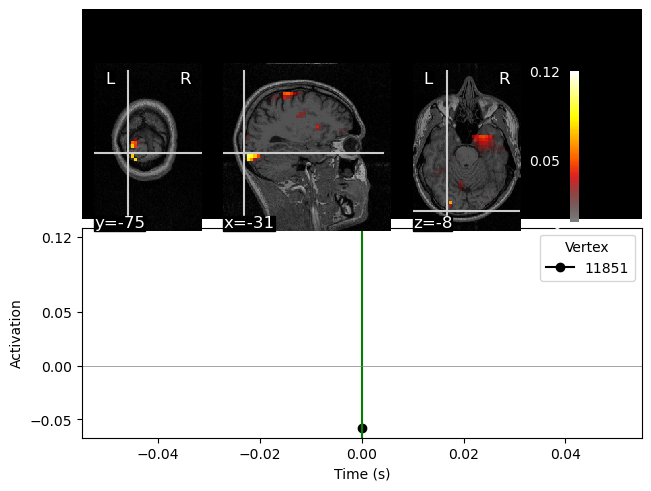

In [26]:
src = fwd['src'] 
%matplotlib inline

brain = stc_grel.plot(src=src,subject=fs_subject, subjects_dir=fs_root, mode='stat_map',initial_pos = [-3,-9,0],clim=dict(kind='value', lims=[0,0.05,0.12]));

Note the sources of gamma activity in early visual cortex. 

## Preregistration and publications

Example for text to be used for publications and preregistration:

"Dynamic Imaging of Coherent Sources (DICS) [1] was used to localise modulations in oscillatory brain activity. To identify changes in the alpha band, cross-spectral density (CSD) was computed for the 8–12 Hz range using a multi-taper method with 2 Hz spectral smoothing. For the analysis of alpha power suppression, CSD matrices were calculated for two time intervals: -700 to -200 ms (pre-cue) and 100 to 600 ms (post-cue), using a single DPSS taper. These CSDs were combined and used with the forward model to construct a common spatial filter. The data rank was estimated first, and for each source, the orientation was optimised to maximise the output power. The spatial filter was then applied to the common CSDs to compute the relative change in alpha power, using a regularisation parameter of 5%. A similar procedure was followed for the gamma band, focusing on the 70–80 Hz range with 8 Hz spectral smoothing, which resulted in the use of three DPSS tapers. For this analysis, the pre-stimulus interval was -0.6 to -0.1 s, and the post-stimulus interval was 0 to 0.5 s, relative to the onset of the visual gratings. Finally, the source-reconstructed data were co-registered and mapped to each participant’s structural MRI."

## References

1. Gross, J., Kujala, J., Hämäläinen, M., Timmermann, L., Schnitzler, A., & Salmelin, R. (2001). Dynamic imaging of coherent sources: Studying neural interactions in the human brain. *Proceedings of the National Academy of Sciences of the United States of America*, **98**(2), 694–699. https://doi.org/10.1073/pnas.98.2.694

2. Engemann, D. A., & Gramfort, A. (2015). Automated model selection in covariance estimation and spatial whitening of MEG and EEG signals. *NeuroImage*, **108**, 328–342. https://doi.org/10.1016/j.neuroimage.2014.12.040

3. Sekihara, K., Hild, K. E., Dalal, S. S., & Nagarajan, S. S. (2008). Performance of prewhitening beamforming in MEG dual experimental conditions. *IEEE Transactions on Biomedical Engineering*, **55**(3), 1112–1121. https://doi.org/10.1109/TBME.2007.912427

4. van Vliet, M., Liljeström, M., Aro, S., Salmelin, R., & Kujala, J. (2018). Analysis of Functional Connectivity and Oscillatory Power Using DICS: From Raw MEG Data to Group-Level Statistics in Python. *Frontiers in Neuroscience*, **12**, 586. https://doi.org/10.3389/fnins.2018.00586

5. Westner, B. U., Dalal, S. S., Gramfort, A., Litvak, V., Mosher, J. C., Oostenveld, R., & Schoffelen, J. M. (2021). A unified view on beamformers for M/EEG source reconstruction. *NeuroImage*, **246**, 118789. https://doi.org/10.1016/j.neuroimage.2021.118789
